## <font color='darkblue'>Preface</font>
([article source](https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137)) <font size='3ptx'><b>Learn to use a tool that shows how each feature affects every prediction of the model</b></font>

Machine Learning models are often black boxes that makes their interpretation difficult. In order to understand what are the main features that affect the output of the model, <b>we need Explainable Machine Learning techniques that unravel some of these aspects.</b>

**One of these techniques is the [SHAP](https://shap.readthedocs.io/en/latest/index.html) method, used to explain how each feature affects the model, and allows local and global analysis for the dataset and problem at hand.**

<a id='sect0'></a>
### <font color='darkgreen'>Agenda</font>
* <font size='3ptx'><b><a href='#sect1'>SHAP Values</a></b></font>
* <font size='3ptx'><b><a href='#sect2'>Some plots of the SHAP library</a></b></font>
* <font size='3ptx'><b><a href='#sect3'>Supplement</a></b></font>

<a id='sect1'></a>
## <font color='darkblue'>SHAP Values</font>
<font size='3ptx'>**SHAP values** (<font color='brown'>**SH**apley **A**dditive ex**P**lanations</font>) **is a method based on cooperative game theory and used to increase transparency and interpretability of machine learning models**.</font>

**Linear models, for example, can use their coefficients as a metric for the overall importance of each feature, but they are scaled with the scale of the variable itself, which might lead to distortions and misinterpretations**. Also, the coefficient cannot account for the local importance of the feature, and how it changes with lower or higher values. The same can be said for feature importances of tree-based models, and this is why SHAP is useful for interpretability of models.
> <font color='darkred'><b>Important:</b></font> while SHAP shows the contribution or the importance of each feature on the prediction of the model, it does not evaluate the quality of the prediction itself.
<br/>

Consider a coooperative game with the same number of players as the name of features. <b>SHAP will disclose the individual contribution of each player</b> (<font color='brown'>or feature</font>) <b>on the output of the model, for each example or observation</b>.

To use SHAP in Python we need to install SHAP module:

In [4]:
#!pip install shap

### <font color='darkgreen'>Import necessary modules</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as R2
from scipy.special import softmax
import shap
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

plt.style.use('default')
plt.rcParams['figure.figsize'] = [8, 4]

### <font color='darkgreen'>Example: California Housing Dataset</font>
Given the California Housing Dataset (<font color='brown'>available on the</font> [scikit-learn library](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset)), we need to train our model. In our example, we can import the California Housing dataset directly from the sklearn library and train any model, such as a Random Forest Regressor

In [5]:
# California Housing Prices
dataset = fetch_california_housing(as_frame=True)
dataset.__class__

sklearn.utils.Bunch

In [6]:
# To save time, we only deal with the front 1000 records
X = dataset['data'][:1000]
y = dataset['target'][:1000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Prepares a default instance of the random forest regressor
model = RandomForestRegressor()

# Fits the model on the data
model.fit(X_train, y_train)

RandomForestRegressor()

To compute SHAP values for the model, we need to create an [**Explainer**](https://shap.readthedocs.io/en/latest/generated/shap.Explainer.html#shap.Explainer) object and use it to evaluate a sample or the full dataset:

In [7]:
%%time
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Exact explainer: 201it [00:36,  4.38it/s]                                                                                              

CPU times: user 36.1 s, sys: 366 ms, total: 36.4 s
Wall time: 36.3 s


The `shap_values` variable will have three attributes: `.values`, `.base_values` and `.data`:
* The `.data` attribute is simply a copy of the input data
* `.base_values` is the expected value of the target, or the average target value of all the input data
* and `.values` are the SHAP values for each example.
<br/>

If we are only interested in the SHAP values, we can use the <font color='blue'>explainer.shap_values()</font> method:

```python
# Evaluate SHAP values
shap_values = explainer.shap_values(X)
```
<br/>

If we simply want the feature importances as determined by SHAP algorithm, we need to take the mean average value for each feature.

In [8]:
from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
        
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {
        fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {
        fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

In [9]:
# Prints the SHAP feature importances
print_feature_importances_shap_values(shap_values, X_test.columns)

MedInc -> 0.4329 (softmax = 0.1709)
AveOccup -> 0.1568 (softmax = 0.1297)
Latitude -> 0.0898 (softmax = 0.1213)
AveRooms -> 0.0863 (softmax = 0.1208)
Longitude -> 0.0623 (softmax = 0.1180)
Population -> 0.0298 (softmax = 0.1142)
HouseAge -> 0.0203 (softmax = 0.1131)
AveBedrms -> 0.0102 (softmax = 0.1120)


<a id='sect2'></a>
## <font color='darkblue'>Some plots of the SHAP library</font> ([back](#sect0))
* <font size='3ptx'><b><a href='#sect2_1'>Bar plot</a></b></font>
* <font size='3ptx'><b><a href='#sect2_2'>Summary plot: beeswarm</a></b></font>
* <font size='3ptx'><b><a href='#sect2_3'>Summary plot: violin</a></b></font>
* <font size='3ptx'><b><a href='#sect2_4'>Local bar plot</a></b></font>
* <font size='3ptx'><b><a href='#sect2_5'>Waterfall plot</a></b></font>
* <font size='3ptx'><b><a href='#sect2_6'>Force plot</a></b></font>
<br/>

<font size='3ptx'><b>It is also possible to use the SHAP library to plot waterfall or beeswarm plots as the example above, or partial dependecy plots as well.</b></font>

<a id='sect2_1'></a>
### <font color='darkgreen'>Bar plot</font>
For analysis of the global effect of the features we can use the following plots ([API](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html)):

In [16]:
#help(shap.plots.bar)

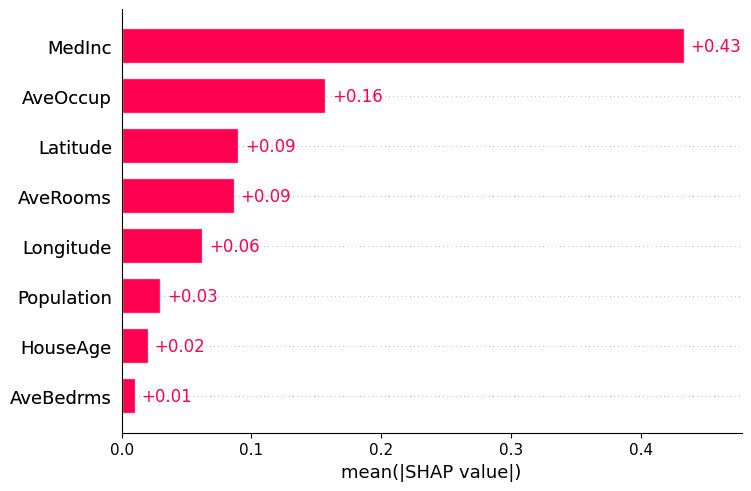

In [14]:
shap.plots.bar(shap_values)

Here the features are ordered from the highest to the lowest effect on the prediction. It takes in account the absolute SHAP value, so it does not matter if the feature affects the prediction in a positive or negative way.

<a id='sect2_2'></a>
### <font color='darkgreen'>Summary plot: beeswarm</font>
On the beeswarm below, the features are also ordered by their effect on prediction, but <b>we can also see how higher and lower values of the feature will affect the result</b>. ([API](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html))

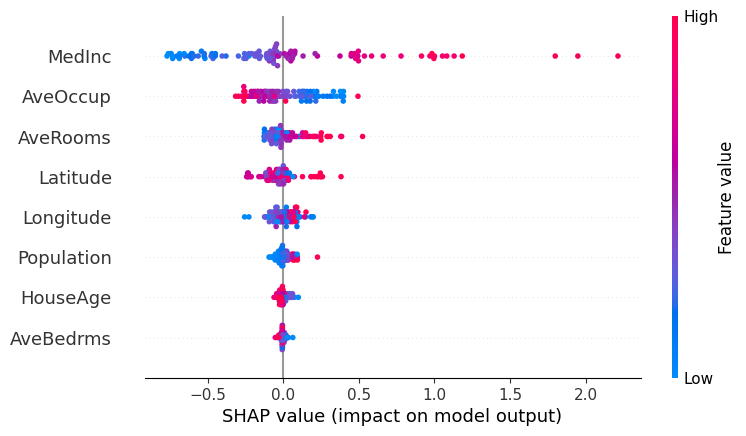

In [17]:
# Plots the beeswarm
shap.plots.beeswarm(shap_values.sample(100))

You can show all examples below in summary plot below:

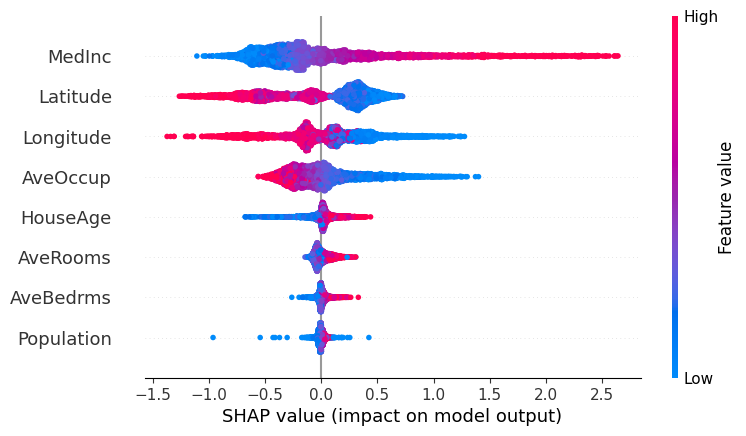

In [12]:
shap.summary_plot(shap_values)

All the little dots on the plot represent a single observation. The horizontal axis represents the SHAP value, while the color of the point shows us if that observation has a higher or a lower value, when compared to other observations.

In this example, **higher latitudes and longitudes have a negative impact on the prediction, while lower values have a positive impact.**

<a id='sect2_3'></a>
### <font color='darkgreen'>Summary plot: violin</font>
Another way to see the information of the beeswarm is by using the violin plot:

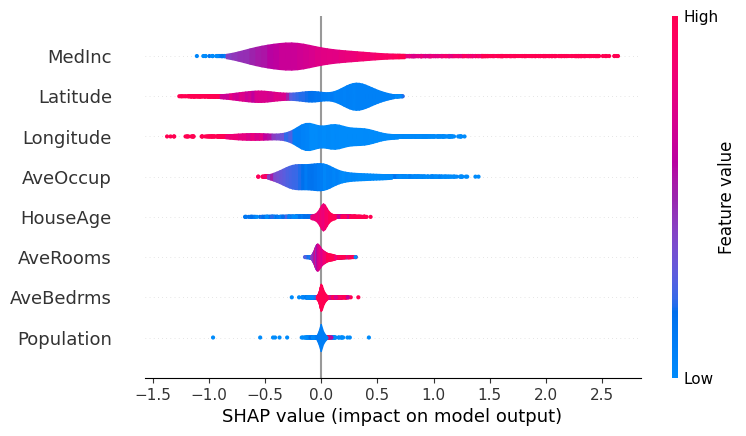

In [14]:
shap.summary_plot(shap_values, plot_type='violin')

For analysis of local, instance-wise effects, we can use the following plots on single observations (<font color='brown'>in the examples below I used</font> `shap_values[0]`).

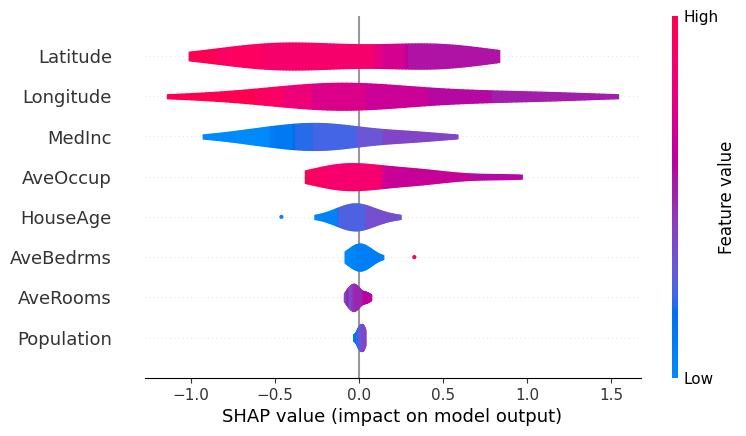

In [16]:
# Violin plot on front 10 instances
shap.summary_plot(shap_values[:10], plot_type='violin')

<a id='sect2_4'></a>
### <font color='darkgreen'>Local bar plot</font>

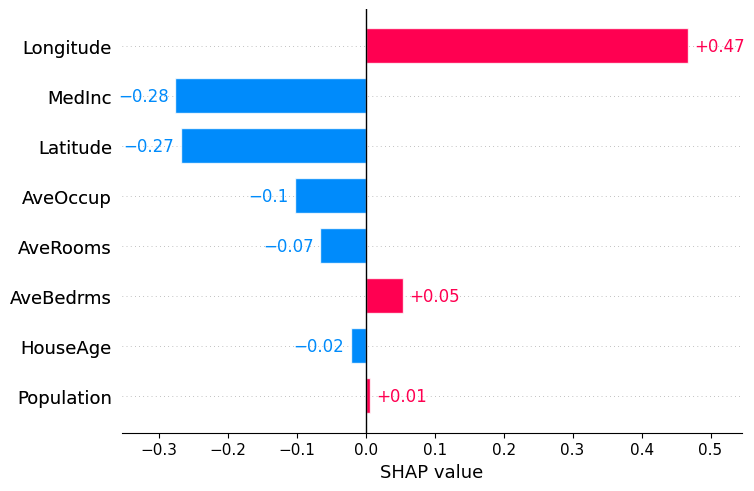

In [20]:
# The result of front 3 instances
shap.plots.bar(shap_values[0])

**This plot shows us what are the main features affecting the prediction of a single observation**, and the magnitude of the SHAP value for each feature.

<a id='sect2_5'></a>
### <font color='darkgreen'>Waterfall plot</font>
The waterfall plot has the same information, represented in a different manner. **Here we can see how the sum of all the SHAP values equals the difference between the prediction** $f(x)$ **and the expected value** $E[f(x)]$.

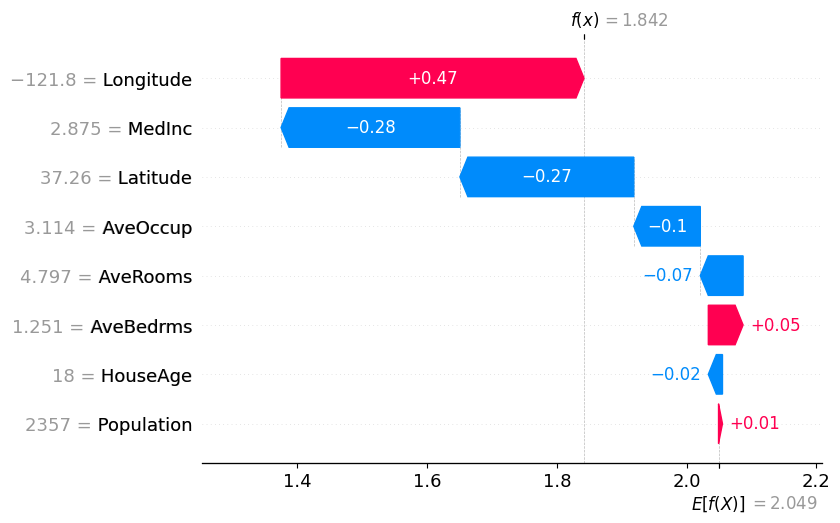

In [24]:
shap.plots.waterfall(shap_values[0])

<a id='sect2_6'></a>
### <font color='darkgreen'>Force plot</font>
The force plot is another way to see the effect each feature has on the prediction, for a given observation. In this plot the positive SHAP values are displayed on the left side and the negative on the right side, as if competing against each other. The highlighted value is the prediction for that observation.

In [19]:
shap.initjs()
shap.plots.force(shap_values[0])

<a id='sect3'></a>
## <font color='darkblue'>Supplement</font> ([back](#sect0))
* [Notebook used in the original article](https://github.com/vinyluis/Articles/blob/main/Boruta%20SHAP/SHAP%20Values.ipynb)
* [SHAP API Reference](https://shap.readthedocs.io/en/latest/api.html)